In [3]:
import cnn_functions
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torchvision import  transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.io import read_image
from torch.utils.data import Dataset, Subset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Multiclass output

In [4]:
labels_map = {
    0: "REAL Truck",
    1: "REAL Car",
    2: "REAL Bird",
    3: "REAL Cat",
    4: "REAL Deer",
    5: "REAL Dog",
    6: "REAL Frog",
    7: "REAL Horse",
    8: "REAL Ship",
    9: "REAL Plane",
    10: "FAKE Truck",
    11: "FAKE Car",
    12: "FAKE Bird",
    13: "FAKE Cat",
    14: "FAKE Deer",
    15: "FAKE Dog",
    16: "FAKE Frog",
    17: "FAKE Horse",
    18: "FAKE Ship",
    19: "FAKE Plane"
}

class MulticlassDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        self.img_dir = img_dir
        self.img_labels = []
        self.img_paths = []
        for g, generated in enumerate(["REAL", "FAKE"]):
            image_files = os.listdir(img_dir + "/" + generated)
            for label, image_name in enumerate(image_files):
                self.img_labels.append(label%10 + g*10)
                self.img_paths.append(os.path.join(generated, image_name))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_paths[idx])
        image = read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
# Compose the transform to perform on the data
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# 100k samples for training
train_ds = MulticlassDataset(img_dir='./archive/train', transform=transform)

# 10k samples for validation and 10k samples for testing
test_val_ds= MulticlassDataset(img_dir='./archive/test', transform=transform)
# Perform a stratified split
idx_train, idx_val = train_test_split(
    range(len(test_val_ds)),
    test_size=0.5,  # 50-50 split
    stratify=test_val_ds.img_labels,
    random_state=0
)
# Define the subsets
test_ds = Subset(test_val_ds, idx_train)
validation_ds = Subset(test_val_ds, idx_val)

# Feature extraction

In [12]:
def multiclass_feature_extraction(lr):
    # Load the pretrained ResNet18 model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # Freeze all layers in the network
    for param in model.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer
    model.fc = torch.nn.Linear(512, 20) 
  
    # Load the model into the GPU
    model = model.to(device)
    # Ensure the optimizer only updates the parameters of the last layer
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
    
    return model, optimizer



 - multiclass_feature_extraction_lr0001_batch32_epochs5

Epoch 1; Train err = 62.03; Val err = 62.11; Loss: 2.3602
Epoch 2; Train err = 58.25; Val err = 58.57; Loss: 2.0100
Epoch 3; Train err = 57.53; Val err = 57.91; Loss: 1.9316
Epoch 4; Train err = 56.65; Val err = 57.40; Loss: 1.8944
Epoch 5; Train err = 55.98; Val err = 56.28; Loss: 1.8738


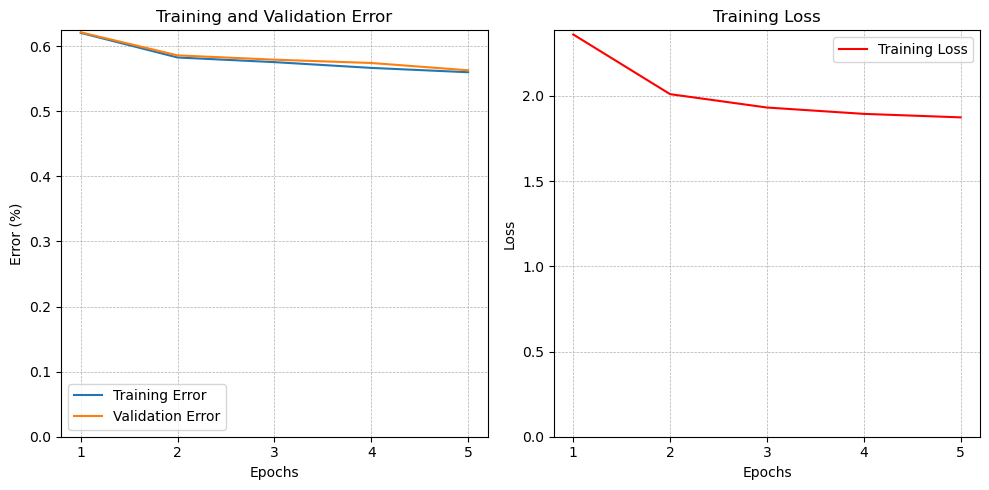

In [13]:
epochs = 5
learning_rates = [0.0001]#[0.0001, 0.00001]
batch_sizes = [32]#[32, 128]

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(validation_ds, batch_size=1000)

        model, opt = multiclass_feature_extraction(lr)

        print(f"\n\n - multiclass_feature_extraction_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}\n")

        train_acc, val_acc, train_loss = cnn_functions.train_network(opt, model, device, epochs, train_dl, val_dl)

        cnn_functions.plot_accuracies(train_acc, val_acc, train_loss)

        #torch.save(model.state_dict(), f'./weights/multiclass_feature_extraction_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}.pth')

# Feature extraction (1 hidden layer)

In [5]:
def multiclass_extraction_hidden(lr):
    # Load the pretrained ResNet18 model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # Freeze all layers in the network
    for param in model.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer
    model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 128),  # Additional layer
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, 20)  # Output layer
    )

    # Load the model into the GPU
    model = model.to(device)
    # Ensure the optimizer only updates the parameters of the last layer
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
    
    return model, optimizer



 - multiclass_extraction_hidden_lr001_batch8_epochs30

Epoch 1; Train err = 66.74; Val err = 67.43; Loss: 2.4878
Epoch 2; Train err = 66.20; Val err = 66.43; Loss: 2.4120
Epoch 3; Train err = 66.00; Val err = 66.49; Loss: 2.3963
Epoch 4; Train err = 65.14; Val err = 65.43; Loss: 2.3940
Epoch 5; Train err = 64.47; Val err = 64.38; Loss: 2.3891
Epoch 10; Train err = 64.89; Val err = 64.40; Loss: 2.3905
Epoch 15; Train err = 64.12; Val err = 64.09; Loss: 2.3952
Epoch 20; Train err = 64.38; Val err = 64.69; Loss: 2.3949
Epoch 25; Train err = 63.35; Val err = 64.13; Loss: 2.3884
Epoch 30; Train err = 64.45; Val err = 64.68; Loss: 2.3911


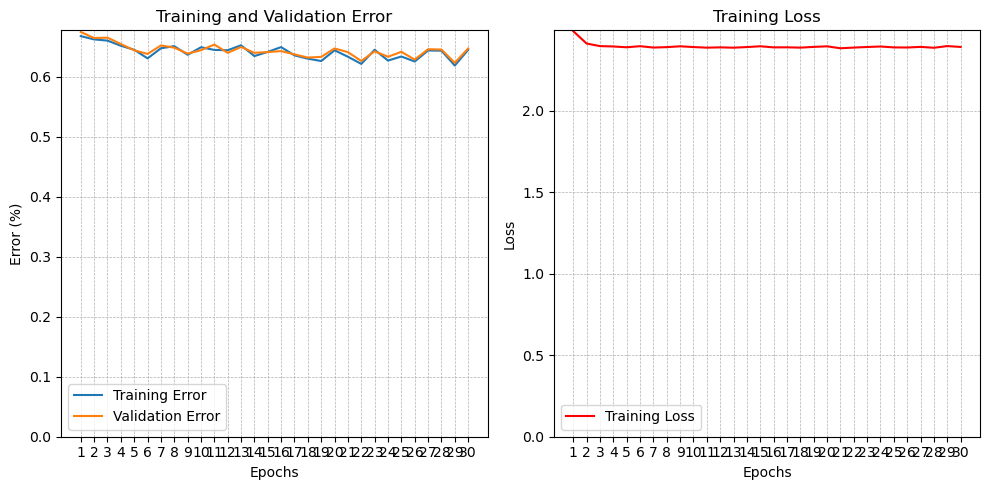



 - multiclass_extraction_hidden_lr001_batch128_epochs30

Epoch 1; Train err = 57.18; Val err = 57.88; Loss: 2.1953
Epoch 2; Train err = 55.66; Val err = 56.82; Loss: 1.9791
Epoch 3; Train err = 54.78; Val err = 56.35; Loss: 1.9375
Epoch 4; Train err = 53.29; Val err = 55.15; Loss: 1.9136
Epoch 5; Train err = 52.78; Val err = 54.77; Loss: 1.8973
Epoch 10; Train err = 51.16; Val err = 53.73; Loss: 1.8460
Epoch 15; Train err = 50.33; Val err = 52.89; Loss: 1.8256
Epoch 20; Train err = 50.26; Val err = 53.48; Loss: 1.8152
Epoch 25; Train err = 49.20; Val err = 52.28; Loss: 1.8062
Epoch 30; Train err = 49.24; Val err = 52.84; Loss: 1.8004


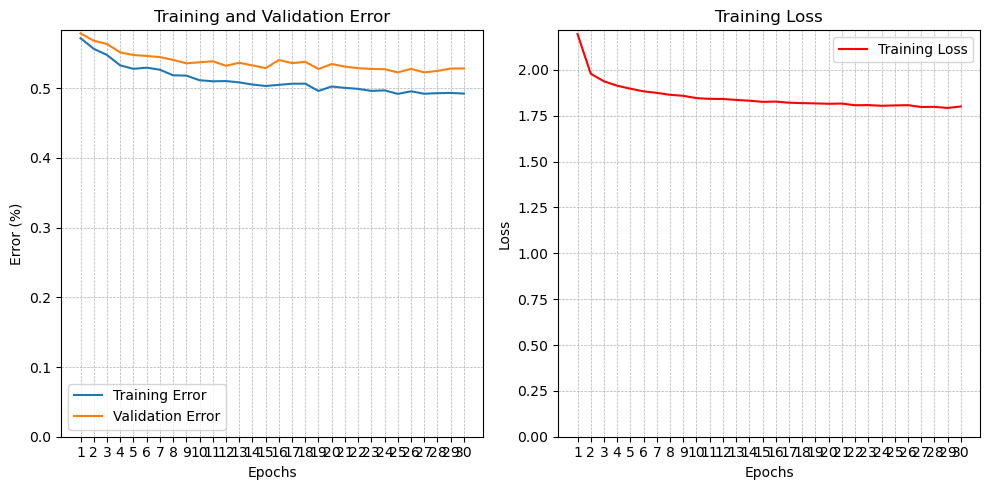



 - multiclass_extraction_hidden_lr0001_batch8_epochs30

Epoch 1; Train err = 64.30; Val err = 64.86; Loss: 2.4616
Epoch 2; Train err = 62.01; Val err = 62.44; Loss: 2.2340
Epoch 3; Train err = 60.75; Val err = 60.49; Loss: 2.1851
Epoch 4; Train err = 59.85; Val err = 60.43; Loss: 2.1630
Epoch 5; Train err = 60.46; Val err = 60.82; Loss: 2.1531
Epoch 10; Train err = 58.83; Val err = 58.80; Loss: 2.1200
Epoch 15; Train err = 58.64; Val err = 58.28; Loss: 2.1139
Epoch 20; Train err = 58.31; Val err = 57.94; Loss: 2.1021
Epoch 25; Train err = 58.61; Val err = 58.81; Loss: 2.0955
Epoch 30; Train err = 57.53; Val err = 58.32; Loss: 2.0924


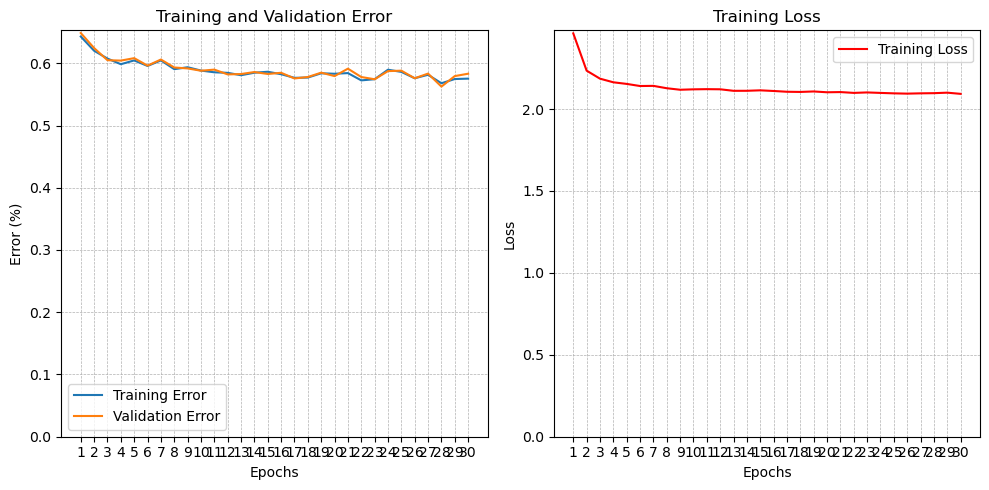



 - multiclass_extraction_hidden_lr0001_batch128_epochs30

Epoch 1; Train err = 64.20; Val err = 64.84; Loss: 2.6476
Epoch 2; Train err = 60.08; Val err = 60.74; Loss: 2.2338
Epoch 3; Train err = 58.25; Val err = 58.82; Loss: 2.1021
Epoch 4; Train err = 57.16; Val err = 58.21; Loss: 2.0287
Epoch 5; Train err = 56.26; Val err = 56.90; Loss: 1.9879
Epoch 10; Train err = 54.30; Val err = 55.86; Loss: 1.8860
Epoch 15; Train err = 52.96; Val err = 54.07; Loss: 1.8366
Epoch 20; Train err = 51.96; Val err = 53.96; Loss: 1.8112
Epoch 25; Train err = 51.04; Val err = 53.08; Loss: 1.7892
Epoch 30; Train err = 50.69; Val err = 53.21; Loss: 1.7776


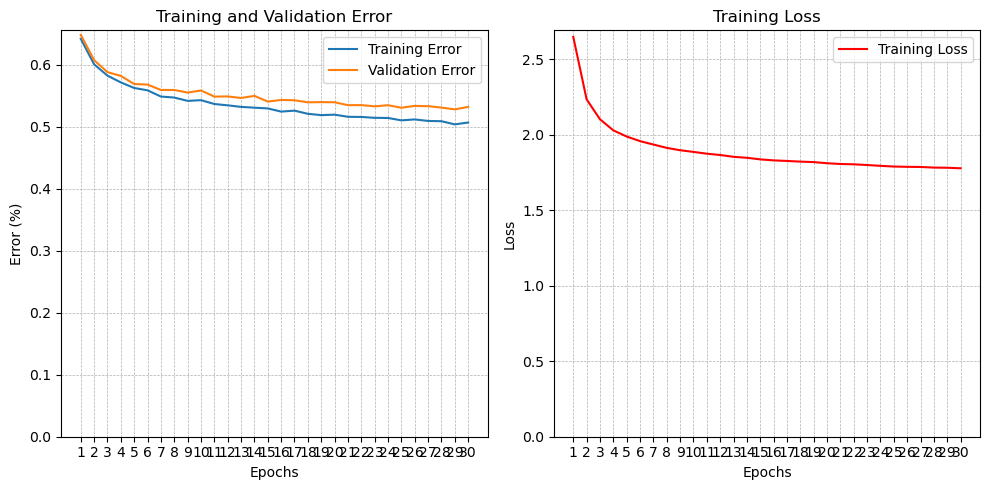



 - multiclass_extraction_hidden_lr-05_batch8_epochs30

Epoch 1; Train err = 76.89; Val err = 77.42; Loss: 2.8949
Epoch 2; Train err = 70.51; Val err = 71.28; Loss: 2.6528
Epoch 3; Train err = 68.19; Val err = 68.46; Loss: 2.5035
Epoch 4; Train err = 66.20; Val err = 66.58; Loss: 2.4165
Epoch 5; Train err = 64.47; Val err = 65.12; Loss: 2.3603
Epoch 10; Train err = 62.42; Val err = 62.94; Loss: 2.2419
Epoch 15; Train err = 61.30; Val err = 62.26; Loss: 2.1890
Epoch 20; Train err = 59.22; Val err = 60.06; Loss: 2.1628
Epoch 25; Train err = 60.00; Val err = 60.13; Loss: 2.1456
Epoch 30; Train err = 59.65; Val err = 60.26; Loss: 2.1334


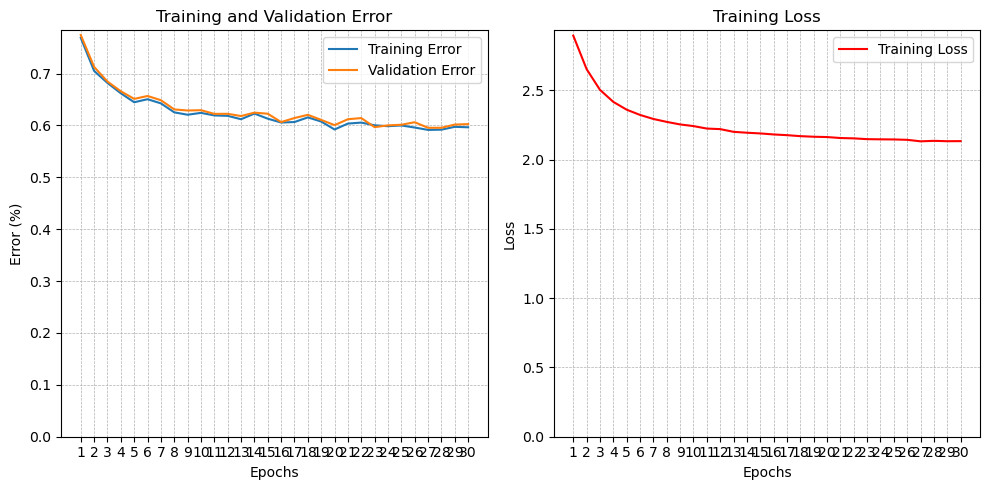



 - multiclass_extraction_hidden_lr-05_batch128_epochs30

Epoch 1; Train err = 88.48; Val err = 88.64; Loss: 3.0067
Epoch 2; Train err = 80.78; Val err = 81.33; Loss: 2.9010
Epoch 3; Train err = 75.12; Val err = 75.90; Loss: 2.8014
Epoch 4; Train err = 71.97; Val err = 72.67; Loss: 2.7022
Epoch 5; Train err = 69.71; Val err = 69.97; Loss: 2.6162
Epoch 10; Train err = 63.65; Val err = 63.65; Loss: 2.3498
Epoch 15; Train err = 61.50; Val err = 61.22; Loss: 2.2194
Epoch 20; Train err = 59.74; Val err = 59.83; Loss: 2.1389
Epoch 25; Train err = 58.83; Val err = 59.45; Loss: 2.0908
Epoch 30; Train err = 58.24; Val err = 58.53; Loss: 2.0464


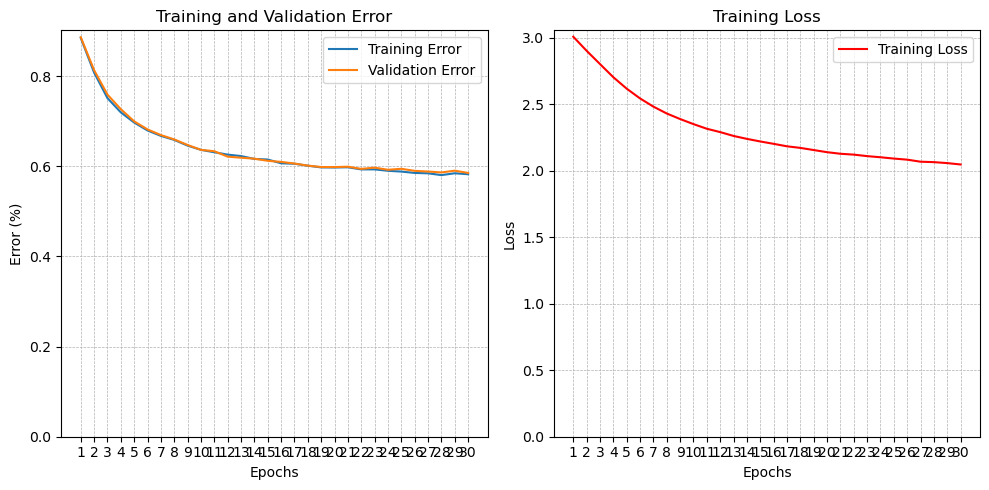

In [15]:
epochs = 30
learning_rates = [0.001, 0.0001, 0.00001]
batch_sizes = [8, 128]

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(validation_ds, batch_size=1000)

        model, opt = multiclass_extraction_hidden(lr)

        print(f"\n\n - multiclass_extraction_hidden_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}\n")

        train_acc, val_acc, train_loss = cnn_functions.train_network(opt, model, device, epochs, train_dl, val_dl)

        cnn_functions.plot_accuracies(train_acc, val_acc, train_loss)

        torch.save(model.state_dict(), f'./weights/multiclass_extraction_hidden_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}.pth')

# Feature extraction (2 hidden layers)

In [7]:
def multiclass_extraction_double_hidden(lr):
    # Load the pretrained ResNet18 model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # Freeze all layers in the network
    for param in model.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer
    model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 128),  # Additional layer
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(128, 20)  # Output layer
    )

    # Load the model into the GPU
    model = model.to(device)
    # Ensure the optimizer only updates the parameters of the last layer
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
    
    return model, optimizer



 - multiclass_extraction_double_hidden001_batch128_epochs30

Epoch 1; Train err = 57.45; Val err = 58.11; Loss: 2.1994
Epoch 2; Train err = 55.39; Val err = 56.32; Loss: 1.9802
Epoch 3; Train err = 54.25; Val err = 55.54; Loss: 1.9395
Epoch 4; Train err = 53.50; Val err = 54.67; Loss: 1.9113
Epoch 5; Train err = 52.86; Val err = 54.62; Loss: 1.8919
Epoch 10; Train err = 51.64; Val err = 54.25; Loss: 1.8525
Epoch 15; Train err = 50.22; Val err = 52.77; Loss: 1.8281
Epoch 20; Train err = 49.90; Val err = 52.51; Loss: 1.8162
Epoch 25; Train err = 49.57; Val err = 52.56; Loss: 1.8065
Epoch 30; Train err = 49.20; Val err = 52.76; Loss: 1.7992


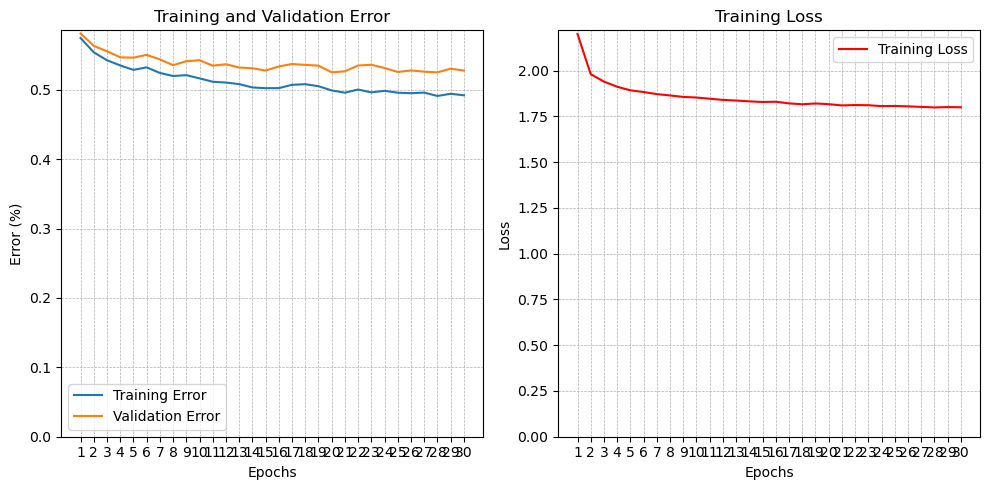



 - multiclass_extraction_double_hidden001_batch256_epochs30

Epoch 1; Train err = 57.46; Val err = 58.30; Loss: 2.2302
Epoch 2; Train err = 55.46; Val err = 56.52; Loss: 1.9692
Epoch 3; Train err = 54.18; Val err = 55.38; Loss: 1.9087
Epoch 4; Train err = 53.34; Val err = 54.95; Loss: 1.8812
Epoch 5; Train err = 52.83; Val err = 54.93; Loss: 1.8562
Epoch 10; Train err = 50.45; Val err = 52.97; Loss: 1.8022
Epoch 15; Train err = 49.34; Val err = 52.37; Loss: 1.7699
Epoch 20; Train err = 48.41; Val err = 52.15; Loss: 1.7493
Epoch 25; Train err = 48.10; Val err = 52.56; Loss: 1.7420
Epoch 30; Train err = 47.46; Val err = 51.63; Loss: 1.7341


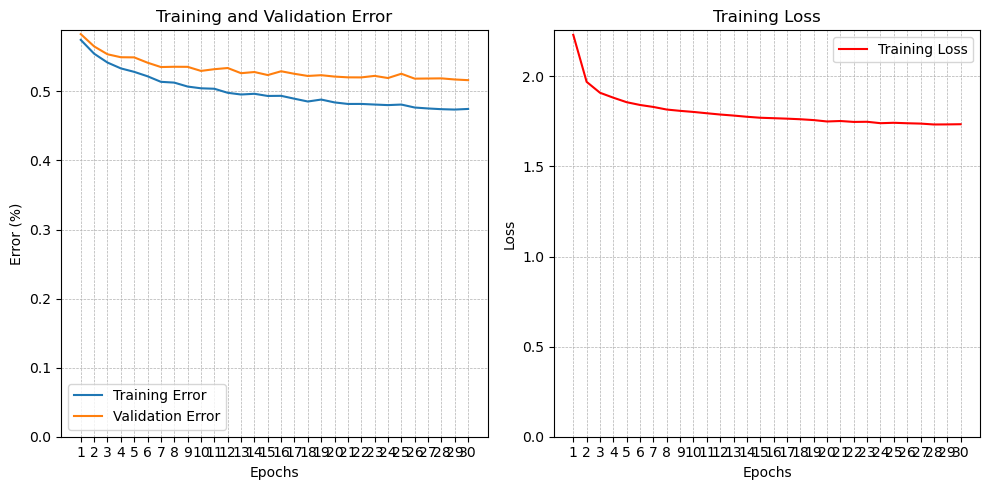



 - multiclass_extraction_double_hidden0001_batch128_epochs30

Epoch 1; Train err = 64.26; Val err = 64.12; Loss: 2.6572
Epoch 2; Train err = 60.07; Val err = 60.18; Loss: 2.2413
Epoch 3; Train err = 58.45; Val err = 58.61; Loss: 2.1001
Epoch 4; Train err = 57.42; Val err = 58.04; Loss: 2.0269
Epoch 5; Train err = 56.44; Val err = 56.93; Loss: 1.9895
Epoch 10; Train err = 53.85; Val err = 54.62; Loss: 1.8831
Epoch 15; Train err = 52.72; Val err = 54.34; Loss: 1.8401
Epoch 20; Train err = 51.75; Val err = 53.54; Loss: 1.8089
Epoch 25; Train err = 51.34; Val err = 52.87; Loss: 1.7886
Epoch 30; Train err = 50.69; Val err = 52.94; Loss: 1.7711


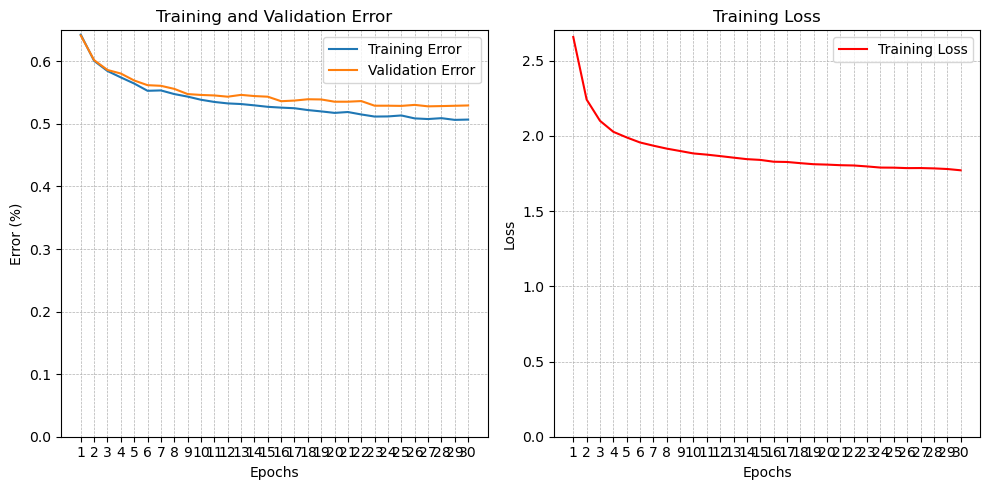



 - multiclass_extraction_double_hidden0001_batch256_epochs30

Epoch 1; Train err = 66.79; Val err = 67.16; Loss: 2.7501
Epoch 2; Train err = 61.70; Val err = 62.15; Loss: 2.3312
Epoch 3; Train err = 59.49; Val err = 60.16; Loss: 2.1731
Epoch 4; Train err = 58.20; Val err = 58.40; Loss: 2.0908
Epoch 5; Train err = 57.40; Val err = 58.15; Loss: 2.0344
Epoch 10; Train err = 54.78; Val err = 55.85; Loss: 1.9060
Epoch 15; Train err = 53.57; Val err = 55.02; Loss: 1.8504
Epoch 20; Train err = 52.52; Val err = 54.08; Loss: 1.8148
Epoch 25; Train err = 51.77; Val err = 53.84; Loss: 1.7942
Epoch 30; Train err = 51.05; Val err = 53.29; Loss: 1.7744


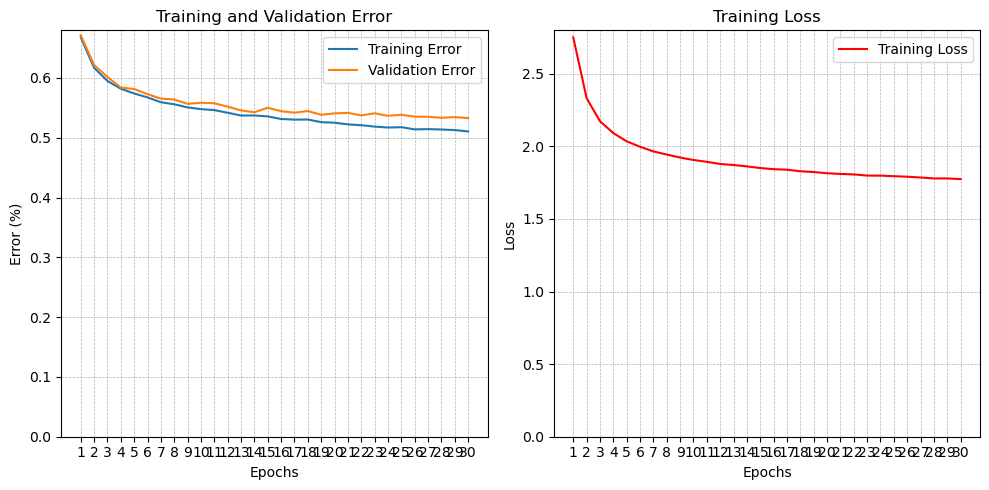

In [7]:
epochs = 30
learning_rates = [0.001, 0.0001]
batch_sizes = [128, 256]

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(validation_ds, batch_size=1000)

        model, opt = multiclass_extraction_double_hidden(lr)

        print(f"\n\n - multiclass_extraction_double_hidden{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}\n")

        train_acc, val_acc, train_loss = cnn_functions.train_network(opt, model, device, epochs, train_dl, val_dl)

        cnn_functions.plot_accuracies(train_acc, val_acc, train_loss)

        torch.save(model.state_dict(), f'./weights/multiclass_extraction_double_hidden_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}.pth')

# Fine tuning

In [8]:
def multiclass_finetuning(lr):
    # Load the pretrained ResNet18 model
    model = resnet18(weights=ResNet18_Weights.DEFAULT)

    # Replace the last fully connected layer
    model.fc = torch.nn.Linear(512, 20)

    # Load the model into the GPU
    model = model.to(device)
    # Ensure the optimizer only updates the parameters of the last layer
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
    
    return model, optimizer



 - multiclass_finetuning_lr0005_batch128_epochs50

Epoch 1; Train err = 58.16; Val err = 59.22; Loss: 2.1437
Epoch 2; Train err = 55.41; Val err = 56.61; Loss: 1.8671
Epoch 3; Train err = 55.17; Val err = 56.58; Loss: 1.8145
Epoch 4; Train err = 54.07; Val err = 55.73; Loss: 1.7919
Epoch 5; Train err = 54.08; Val err = 56.08; Loss: 1.7761
Epoch 10; Train err = 53.12; Val err = 54.67; Loss: 1.7456
Epoch 15; Train err = 53.18; Val err = 54.87; Loss: 1.7396
Epoch 20; Train err = 52.78; Val err = 54.46; Loss: 1.7359
Epoch 25; Train err = 52.99; Val err = 54.53; Loss: 1.7362
Epoch 30; Train err = 52.82; Val err = 55.26; Loss: 1.7376
Epoch 35; Train err = 52.74; Val err = 54.97; Loss: 1.7322
Epoch 40; Train err = 52.90; Val err = 54.55; Loss: 1.7339
Epoch 45; Train err = 52.55; Val err = 54.23; Loss: 1.7370
Epoch 50; Train err = 53.03; Val err = 55.02; Loss: 1.7319


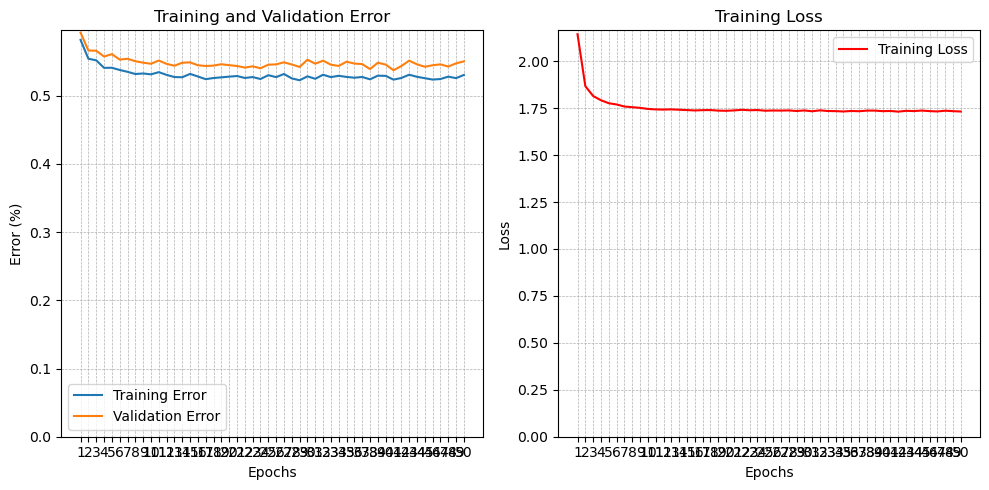



 - multiclass_finetuning_lr0005_batch256_epochs50

Epoch 1; Train err = 58.96; Val err = 59.62; Loss: 2.2458
Epoch 2; Train err = 55.96; Val err = 57.04; Loss: 1.9000
Epoch 3; Train err = 55.23; Val err = 56.47; Loss: 1.8310
Epoch 4; Train err = 54.44; Val err = 55.57; Loss: 1.7973
Epoch 5; Train err = 54.15; Val err = 55.56; Loss: 1.7757
Epoch 10; Train err = 52.88; Val err = 54.50; Loss: 1.7332
Epoch 15; Train err = 52.46; Val err = 54.29; Loss: 1.7175
Epoch 20; Train err = 52.50; Val err = 54.58; Loss: 1.7117
Epoch 25; Train err = 52.58; Val err = 54.81; Loss: 1.7080
Epoch 30; Train err = 52.50; Val err = 54.42; Loss: 1.7044
Epoch 35; Train err = 52.59; Val err = 54.88; Loss: 1.7040
Epoch 40; Train err = 52.20; Val err = 54.22; Loss: 1.7049
Epoch 45; Train err = 52.59; Val err = 54.91; Loss: 1.7030
Epoch 50; Train err = 52.20; Val err = 54.45; Loss: 1.7023


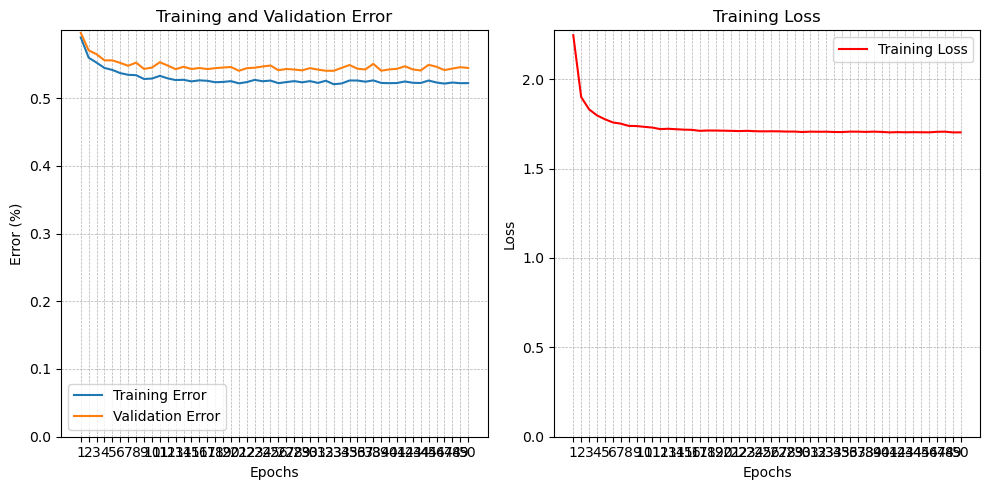



 - multiclass_finetuning_lr-05_batch128_epochs50

Epoch 1; Train err = 74.56; Val err = 75.23; Loss: 2.8170
Epoch 2; Train err = 66.95; Val err = 67.62; Loss: 2.3757
Epoch 3; Train err = 63.56; Val err = 64.44; Loss: 2.1923
Epoch 4; Train err = 61.91; Val err = 62.68; Loss: 2.0926
Epoch 5; Train err = 60.19; Val err = 61.12; Loss: 2.0252
Epoch 10; Train err = 57.00; Val err = 58.11; Loss: 1.8822
Epoch 15; Train err = 55.82; Val err = 56.85; Loss: 1.8266
Epoch 20; Train err = 54.82; Val err = 56.03; Loss: 1.7993
Epoch 25; Train err = 54.29; Val err = 55.70; Loss: 1.7780
Epoch 30; Train err = 54.01; Val err = 55.33; Loss: 1.7653
Epoch 35; Train err = 53.56; Val err = 54.91; Loss: 1.7535
Epoch 40; Train err = 53.30; Val err = 54.51; Loss: 1.7466
Epoch 45; Train err = 53.52; Val err = 54.90; Loss: 1.7387
Epoch 50; Train err = 53.21; Val err = 54.76; Loss: 1.7363


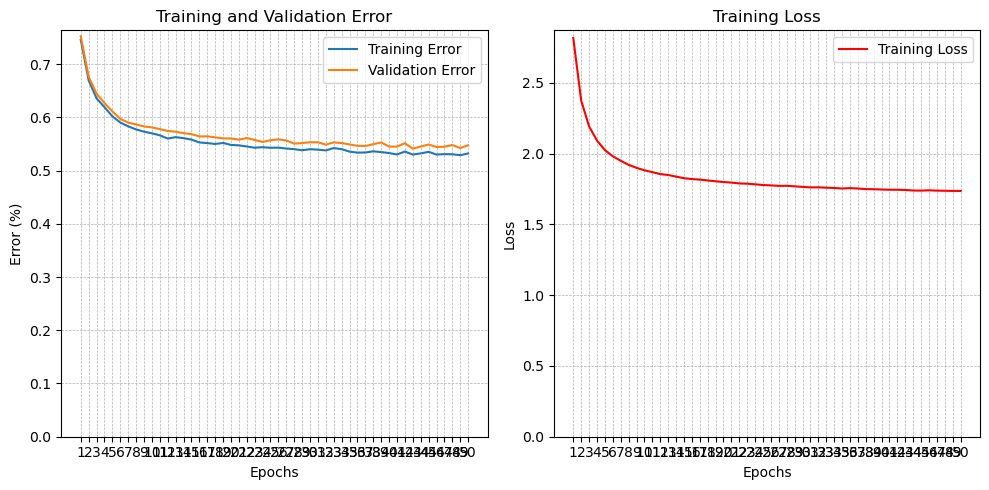



 - multiclass_finetuning_lr-05_batch256_epochs50

Epoch 1; Train err = 79.28; Val err = 80.21; Loss: 2.9006
Epoch 2; Train err = 70.63; Val err = 70.64; Loss: 2.5181
Epoch 3; Train err = 66.37; Val err = 67.00; Loss: 2.3235
Epoch 4; Train err = 64.04; Val err = 64.41; Loss: 2.2069
Epoch 5; Train err = 62.36; Val err = 62.97; Loss: 2.1277
Epoch 10; Train err = 58.48; Val err = 59.55; Loss: 1.9454
Epoch 15; Train err = 56.64; Val err = 57.94; Loss: 1.8692
Epoch 20; Train err = 55.69; Val err = 56.92; Loss: 1.8269
Epoch 25; Train err = 55.10; Val err = 56.38; Loss: 1.8004
Epoch 30; Train err = 54.56; Val err = 56.08; Loss: 1.7822
Epoch 35; Train err = 54.17; Val err = 55.75; Loss: 1.7655
Epoch 40; Train err = 53.82; Val err = 55.07; Loss: 1.7558
Epoch 45; Train err = 53.54; Val err = 54.92; Loss: 1.7469
Epoch 50; Train err = 53.57; Val err = 54.97; Loss: 1.7390


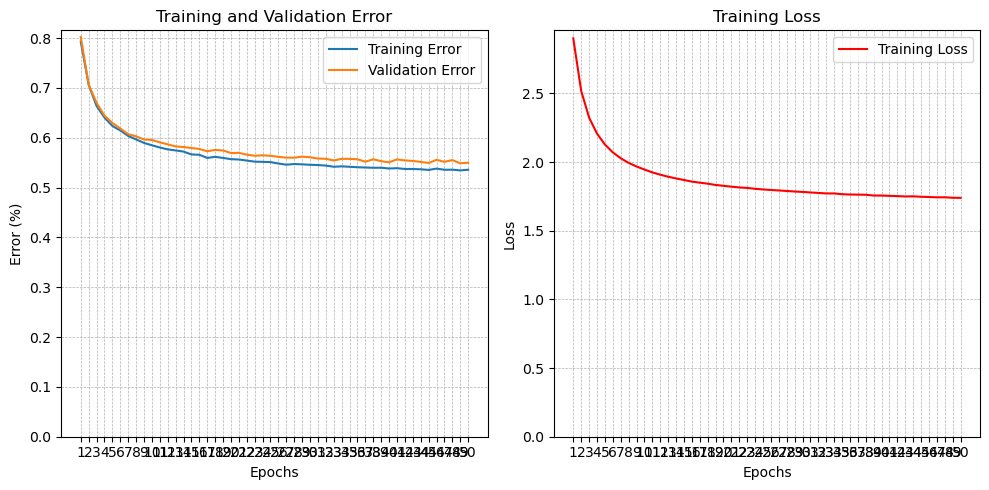

In [9]:
epochs = 50
learning_rates = [0.0005, 0.00005]
batch_sizes = [128, 256]

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(validation_ds, batch_size=1000)

        model, opt = multiclass_finetuning(lr)

        print(f"\n\n - multiclass_finetuning_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}\n")

        train_acc, val_acc, train_loss = cnn_functions.train_network(opt, model, device, epochs, train_dl, val_dl)

        cnn_functions.plot_accuracies(train_acc, val_acc, train_loss)

        torch.save(model.state_dict(), f'./weights/multiclass_finetuning_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}.pth')

# Confusion matrix

In [17]:
test_loader = DataLoader(validation_ds, batch_size=1000, shuffle=True)

model, _ = multiclass_extraction_double_hidden(1)
model.load_state_dict(torch.load('./weights/multiclass_extraction_double_hidden_lr001_batch256_epochs30.pth'))
model.eval()  
device = next(model.parameters()).device

total_correct = 0
total_images = 0
confusion_matrix = torch.zeros(20, 20)  

with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[label.long(), prediction.long()] += 1

accuracy = total_correct / total_images
test_error = 1 - accuracy

print(f'Test accuracy: {accuracy*100:.2f}%')

Test accuracy: 48.37%


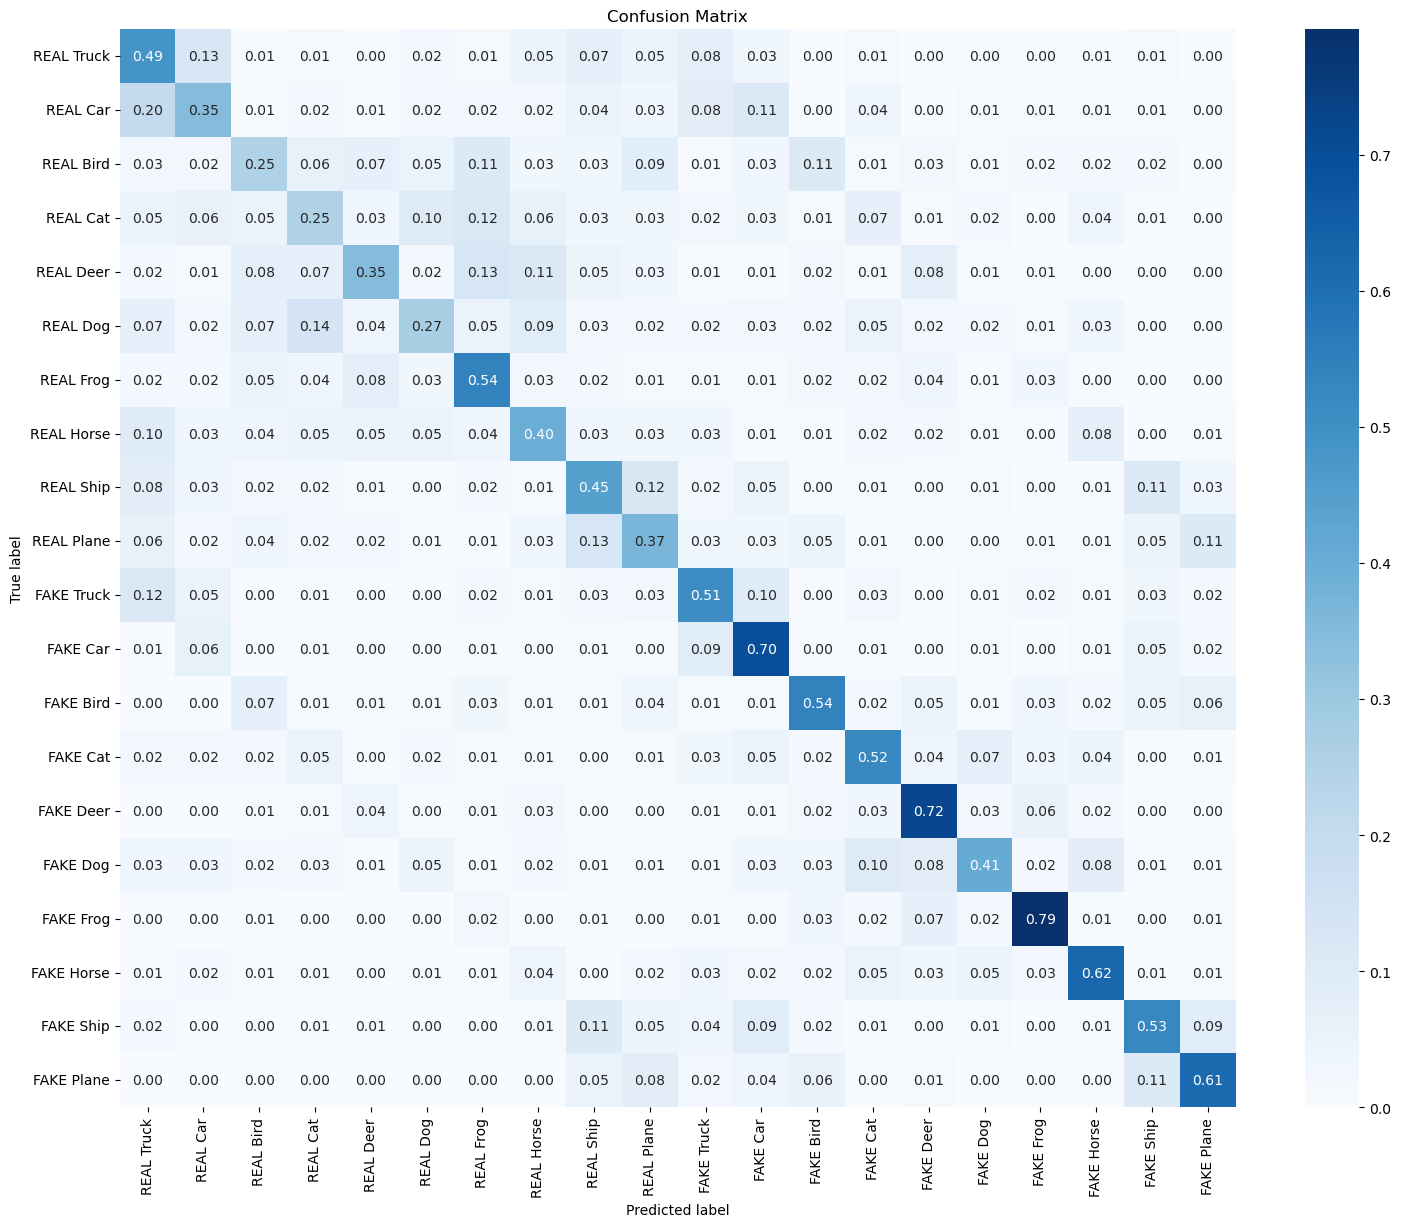

In [16]:
confusion_matrix_np = confusion_matrix.numpy()

def plot_confusion_matrix(cm, class_names):
    # Normalize the confusion matrix.
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(18, 14))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

class_names = []
_ = [class_names.append(labels_map[c]) for c in labels_map] 
plot_confusion_matrix(confusion_matrix_np, class_names)

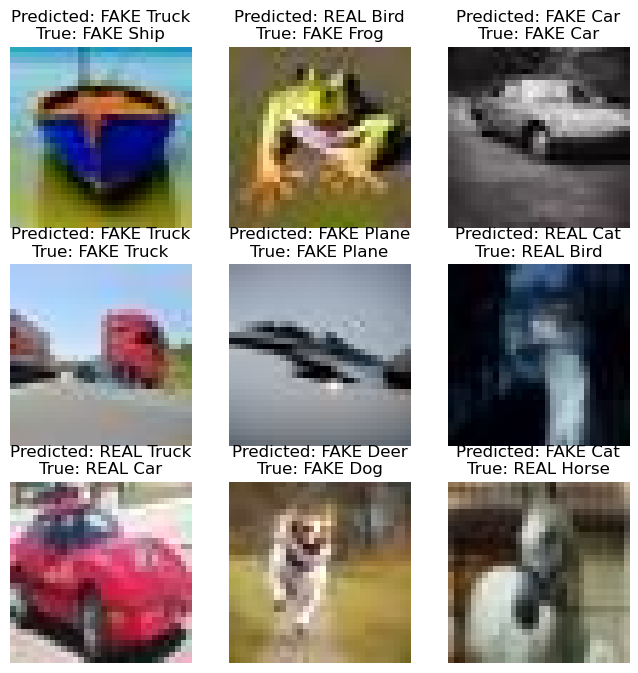

In [18]:
import torch
import matplotlib.pyplot as plt

model.eval()  

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_ds), size=(1,)).item()
    img, true_label = train_ds[sample_idx]
    img_tensor = img.unsqueeze(0)  # Add batch dimension

    # Move to the same device as the model
    img_tensor = img_tensor.to(next(model.parameters()).device)

    with torch.no_grad():  
        logits = model(img_tensor)
        predicted_label = torch.argmax(logits, dim=1).item()

    img = img.cpu().numpy().transpose((1, 2, 0))  # Adjust for matplotlib (H, W, C)

    figure.add_subplot(rows, cols, i)
    plt.title(f'Predicted: {labels_map[predicted_label]}\nTrue: {labels_map[true_label]}')
    plt.axis("off")
    plt.imshow(img)
plt.show()
